In [1]:
import logging

import pandas as pd
import plotly.graph_objects as go
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import DistributionLoss
from ray import tune
from utilsforecast.losses import mae, mse

logging.getLogger("pytorch_lightning").setLevel(logging.INFO)
pd.set_option("display.max_columns", 50)
# torch.set_float32_matmul_precision('high')

## Functions

In [2]:
def plot(df_hist, df_hat, levels=None, model_name=None):
    """
    Plot historical data and forecasts with optional prediction intervals.

    Parameters:
    -----------
    df_hist : DataFrame
        Historical data with columns 'ds' and 'y'
    df_hat : DataFrame
        Forecast data with columns 'ds', 'unique_id', model predictions, and optional prediction intervals
    levels : list of int, optional
        Confidence levels for prediction intervals (e.g., [80, 90])
    """
    dash_styles = ["solid", "dot", "dash", "longdash", "dashdot", "longdashdot"]

    # Extract base model names (without -lo-XX or -hi-XX suffixes)
    models = []
    for col in df_hat.columns:
        if col in ["ds", "unique_id"]:
            continue
        # Check if it's a base model (not a level column)
        if not any(
            col.endswith(f"-lo-{level}") or col.endswith(f"-hi-{level}")
            for level in levels or []
        ):
            models.append(col)

    fig = go.Figure()

    # Add historical data
    fig.add_trace(
        go.Scatter(
            x=df_hist["ds"],
            y=df_hist["y"],
            mode="lines",
            name="Historical",
            line=dict(color="black", width=2),
        )
    )

    # Add forecasts and prediction intervals
    colors = ["blue", "red", "green", "purple", "orange", "brown"]

    for i, model in enumerate(models):
        color = colors[i % len(colors)]

        # Add main forecast line
        fig.add_trace(
            go.Scatter(
                x=df_hat["ds"],
                y=df_hat[model],
                mode="lines",
                name=model,
                line=dict(dash=dash_styles[i % len(dash_styles)], color=color, width=2),
            )
        )

        # Add prediction intervals if levels are provided
        if levels:
            for level in sorted(levels, reverse=True):  # Plot wider intervals first
                lo_col = f"{model}-lo-{level}"
                hi_col = f"{model}-hi-{level}"

                if lo_col in df_hat.columns and hi_col in df_hat.columns:
                    # Add upper bound (invisible line, just for fill)
                    fig.add_trace(
                        go.Scatter(
                            x=df_hat["ds"],
                            y=df_hat[hi_col],
                            mode="lines",
                            line=dict(width=0),
                            showlegend=False,
                            hoverinfo="skip",
                        )
                    )

                    # Add lower bound with fill
                    fig.add_trace(
                        go.Scatter(
                            x=df_hat["ds"],
                            y=df_hat[lo_col],
                            mode="lines",
                            line=dict(width=0),
                            fillcolor=f"rgba({int(color == 'blue') * 0},{int(color == 'red') * 255},{int(color == 'green') * 0},0.{100 - level // 2})",
                            fill="tonexty",
                            name=f"{model} {level}% PI",
                            hoverinfo="skip",
                        )
                    )

    fig.update_layout(
        title="Germany Historical vs Forecast",
        width=1400,
        height=500,
        xaxis_title="Date",
        yaxis_title="Value",
        hovermode="x unified",
    )

    fig.show()

## Load Data

In [3]:
Y_df = pd.read_csv(
    "/mnt/data/oe215/rhindrikson/datasets/load/entsoe-hourly/data.csv", parse_dates=["ds"]
)
futr_df = pd.read_csv(
    "/mnt/data/oe215/rhindrikson/datasets/load/entsoe-hourly/futr.csv", parse_dates=["ds"]
)

In [4]:
# Define validation and test size
n_time = len(Y_df.ds.unique())
val_size = int(0.2 * n_time)
test_size = int(0.2 * n_time)
print(n_time)
print(val_size)
Y_df.groupby("unique_id").head(2)

30644
6128


,Unnamed: 0,ds,y,unique_id,week_day,is_holiday,day_before_holiday,day_after_holiday
0,0,2022-01-01 00:00:00,41535.765,load,5,1,0,0
1,1,2022-01-01 01:00:00,40480.905,load,5,1,0,0


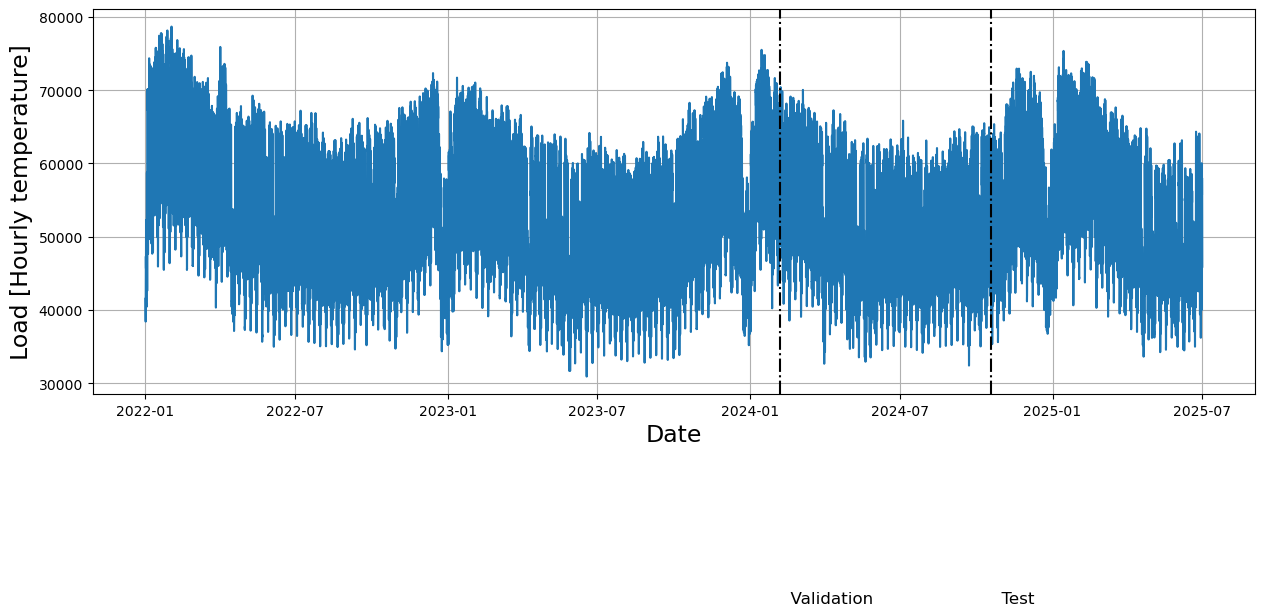

In [5]:
import matplotlib.pyplot as plt

# We are going to plot the temperature of the transformer
# and marking the validation and train splits
u_id = "load"
x_plot = pd.to_datetime(Y_df[Y_df.unique_id == u_id].ds)
y_plot = Y_df[Y_df.unique_id == u_id].y.values

x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]

fig = plt.figure(figsize=(15, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.xlabel("Date", fontsize=17)
plt.ylabel("Load [Hourly temperature]", fontsize=17)

plt.axvline(x_val, color="black", linestyle="-.")
plt.axvline(x_test, color="black", linestyle="-.")
plt.text(x_val, 5, "  Validation", fontsize=12)
plt.text(x_test, 5, "  Test", fontsize=12)

plt.grid()

## Model

In [6]:
horizon = 7 * 24

nhits_config = {
    "learning_rate": tune.choice([1e-3]),  # Initial Learning rate
    "max_steps": tune.choice([1000]),  # Number of SGD steps
    "input_size": tune.choice([104 * horizon]),  # input_size = multiplier * horizon
    "batch_size": tune.choice([7]),  # Number of series in windows
    "windows_batch_size": tune.choice([256]),  # Number of windows in batch
    "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),  # MaxPool's Kernelsize
    "n_freq_downsample": tune.choice(
        [[168, 24, 1], [24, 12, 1], [1, 1, 1]]
    ),  # Interpolation expressivity ratios
    "activation": tune.choice(["ReLU"]),  # Type of non-linear activation
    "n_blocks": tune.choice([[1, 1, 1]]),  # Blocks per each 3 stacks
    "mlp_units": tune.choice(
        [[[512, 512], [512, 512], [512, 512]]]
    ),  # 2 512-Layers per block for each stack
    "interpolation_mode": tune.choice(["linear"]),  # Type of multi-step interpolation
    "val_check_steps": tune.choice([100]),  # Compute validation every 100 epochs
    "random_seed": tune.randint(1, 10),
}

def config_nhits(trial):
    return {
        "input_size": trial.suggest_categorical(          # Length of input window
            "input_size", (48, 48*2, 48*3)                
        ),                                                
        "start_padding_enabled": True,                                          
        "n_blocks": 5 * [1],                              # Length of input window
        "mlp_units": 5 * [[64, 64]],                      # Length of input window
        "n_pool_kernel_size": trial.suggest_categorical(  # MaxPooling Kernel size
            "n_pool_kernel_size",
            (5*[1], 5*[2], 5*[4], [8, 4, 2, 1, 1])
        ),     
        "n_freq_downsample": trial.suggest_categorical(   # Interpolation expressivity ratios
            "n_freq_downsample",
            ([8, 4, 2, 1, 1],  [1, 1, 1, 1, 1])
        ),     
        "learning_rate": trial.suggest_float(             # Initial Learning rate
            "learning_rate",
            low=1e-4,
            high=1e-2,
            log=True,
        ),            
        "scaler_type": None,                              # Scaler type
        "max_steps": 1000,                                # Max number of training iterations
        "batch_size": trial.suggest_categorical(          # Number of series in batch
            "batch_size",
            (1, 4, 10),
        ),                   
        "windows_batch_size": trial.suggest_categorical(  # Number of windows in batch
            "windows_batch_size",
            (128, 256, 512),
        ),      
        "random_seed": trial.suggest_int(                 # Random seed   
            "random_seed",
            low=1,
            high=20,
        ),                      
    }

In [7]:
print(nhits_config)

{'learning_rate': <ray.tune.search.sample.Categorical object at 0x7fc207c78550>, 'max_steps': <ray.tune.search.sample.Categorical object at 0x7fc207cb2190>, 'input_size': <ray.tune.search.sample.Categorical object at 0x7fc207ce10d0>, 'batch_size': <ray.tune.search.sample.Categorical object at 0x7fc207f2a1d0>, 'windows_batch_size': <ray.tune.search.sample.Categorical object at 0x7fc207f2a290>, 'n_pool_kernel_size': <ray.tune.search.sample.Categorical object at 0x7fc207f2a350>, 'n_freq_downsample': <ray.tune.search.sample.Categorical object at 0x7fc207f2a450>, 'activation': <ray.tune.search.sample.Categorical object at 0x7fc207f2a510>, 'n_blocks': <ray.tune.search.sample.Categorical object at 0x7fc207f2a610>, 'mlp_units': <ray.tune.search.sample.Categorical object at 0x7fc207f2a810>, 'interpolation_mode': <ray.tune.search.sample.Categorical object at 0x7fc207f2a910>, 'val_check_steps': <ray.tune.search.sample.Categorical object at 0x7fc207f2aa10>, 'random_seed': <ray.tune.search.sample.I

## Instantiate Model

To instantiate `AutoNHITS` you need to define:

* `h`: forecasting horizon
* `loss`: training loss. Use the `DistributionLoss` to produce probabilistic forecasts.
* `config`: hyperparameter search space. If `None`, the `AutoNHITS` class will use a pre-defined suggested hyperparameter space.
* `num_samples`: number of configurations explored.

If num_samples equals 5, the AutoNHITS model will randomly sample 5 different combinations of hyperparameters from the search space defined in nhits_config.
Each configuration will be trained and evaluated.
The best performing configuration (based on validation performance) will be selected as the final model

For loss, common distribution options include:
- 'Normal' or 'Gaussian' - for normal/gaussian distribution
- 'StudentT' or 'T' - for Student's t-distribution
- 'NegativeBinomial' - for count data
- 'Poisson' - for count data
- 'Tweedie' - for non-negative continuous data



In [8]:
levels = [80, 90]
# loss=MQLoss(level=levels),
loss = DistributionLoss(distribution="Normal", level=levels)
models = [
    AutoNHITS(
        h=horizon,
        loss=loss,
        config=config_nhits,
        num_samples=5,
        backend='optuna'
    )
]

print(models[0])

AutoNHITS


In [9]:
%%capture
nf = NeuralForecast(models=models, freq="h")

Y_hat_df = nf.cross_validation(
    df=Y_df, val_size=val_size, test_size=test_size, n_windows=None
)

[rank: 0] Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA H100 NVL') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 156 K  | train
----------------------------------------------------------
156 K     Trainable params
5         Non-trainable params
156 K     Total para

## Evaluate Results

The `AutoNHITS` class contains a `results` tune attribute that stores information of each configuration explored. It contains the validation loss and best validation hyperparameter.

In [38]:
# nf.models[0].results.get_best_result().config
results = nf.models[0].results.trials_dataframe()
best_config = results.iloc[0, :].to_dict()

loss = best_config["value"]
params = best_config["user_attrs_ALL_PARAMS"]

print("Loss", loss)
print("Params", params)
loss

Loss 11.057435989379883
Params {'input_size': 96, 'start_padding_enabled': True, 'n_blocks': [1, 1, 1, 1, 1], 'mlp_units': [[64, 64], [64, 64], [64, 64], [64, 64], [64, 64]], 'n_pool_kernel_size': [2, 2, 2, 2, 2], 'n_freq_downsample': [1, 1, 1, 1, 1], 'learning_rate': 0.0006876343709825383, 'scaler_type': None, 'max_steps': 1000, 'batch_size': 10, 'windows_batch_size': 128, 'random_seed': 4, 'h': 168, 'loss': DistributionLoss(), 'valid_loss': DistributionLoss()}


11.057435989379883

In [ ]:
y_true = Y_hat_df.y.values
y_hat = Y_hat_df["AutoNHITS"].values

n_series = len(Y_df.unique_id.unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)

print("Parsed results")
print("2. y_true.shape (n_series, n_windows, n_time_out):\t", y_true.shape)
print("2. y_hat.shape  (n_series, n_windows, n_time_out):\t", y_hat.shape)

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))
fig.tight_layout()

series = ['load']
series_idx = 0

for idx, w_idx in enumerate([200, 300, 400]):
  axs[idx].plot(y_true[series_idx, w_idx,:],label='True')
  axs[idx].plot(y_hat[series_idx, w_idx,:],label='Forecast')
  axs[idx].grid()
  axs[idx].set_ylabel(series[series_idx]+f' window {w_idx}', 
                      fontsize=17)
  if idx==2:
    axs[idx].set_xlabel('Forecast Horizon', fontsize=17)
plt.legend()
plt.show()
plt.close()

Finally, we compute the test errors for the two metrics of interest:

$\qquad MAE = \frac{1}{Windows * Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}| \qquad$ and $\qquad MSE = \frac{1}{Windows * Horizon} \sum_{\tau} (y_{\tau} - \hat{y}_{\tau})^{2} \qquad$

In [ ]:
from neuralforecast.losses.numpy import mae, mse

print("MAE: ", mae(y_hat, y_true))
print("MSE: ", mse(y_hat, y_true))